In [69]:
import pyarrow.dataset as ds
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from smiles_blocks.files import REPORTS_DIR,FIGURES_DIR,PROCESSED_DATA_DIR

In [64]:
data_folder = PROCESSED_DATA_DIR / "modelling_data"
results_folder = PROCESSED_DATA_DIR / "models_metrics"
output_folder = REPORTS_DIR / "modeling_results"
output_folder.mkdir(exist_ok=True)
figure_folder = FIGURES_DIR / "modeling_results"
figure_folder.mkdir(exist_ok=True)

In [70]:
modeling_data_dataset = ds.dataset(data_folder, format="parquet")
scanner= modeling_data_dataset.scanner( columns=["nb_random_smiles"])
modeling_data_array = scanner.to_table()["nb_random_smiles"].to_numpy()
modeling_data_array.sum(), modeling_data_array.shape[0]

(np.int64(1258073003360), 281318528)

In [ ]:
1_258_073_003_360

In [ ]:
281_318_528

In [66]:
modeling_data_dataset.schema

smiles: string
nb_unique_smiles: int64
cumulative_count: int64
nb_random_smiles: int64
seed: int64
replica: int64
split: string
-- schema metadata --
smiles: 'SMILES string representation'
nb_unique_smiles: 'Number of unique SMILES found'
cumulative_count: 'Cumulative count of SMILES variations'
nb_random_smiles: 'Number of random SMILES generated'
seed: 'Random seed used for generation'
replica: 'Replica identifier'
unique_smiles: 'Unique SMILES variations found'
split: 'Dataset split'

In [50]:
dataset_modelling_results = ds.dataset(str(results_folder), format="parquet")

In [51]:
modelling_results_df= dataset_modelling_results.to_table().to_pandas()

In [52]:
modelling_results_df

,smiles,split,function,formula,max_nb_unique_smiles,alpha,beta,r_squared,error_log
0,CCCS(=O)c1ccc2[nH]c(=NC(=O)OC)[nH]c2c1,train,sqrt,$y = \alpha \sqrt{\beta x}$,1696.0,16.205026,0.327879,0.605740,invalid value encountered in sqrt; invalid val...
1,CCCS(=O)c1ccc2[nH]c(=NC(=O)OC)[nH]c2c1,train,log,$y = \alpha \log(\beta x)$,1696.0,205.865460,0.074264,0.873224,invalid value encountered in log; invalid valu...
2,CCCS(=O)c1ccc2[nH]c(=NC(=O)OC)[nH]c2c1,train,inverse,$y = \frac{\alpha}{\beta + \frac{1}{x}}$,1696.0,1.278406,0.000702,0.994756,
3,CCCS(=O)c1ccc2[nH]c(=NC(=O)OC)[nH]c2c1,train,inverse2,$y = \frac{\alpha}{1 + \frac{\beta}{x}}$,1696.0,1820.840931,1424.305342,0.994756,
4,CCCS(=O)c1ccc2[nH]c(=NC(=O)OC)[nH]c2c1,train,exp,$y = \alpha (1 - e^{-\beta x})$,1696.0,1671.792438,0.000538,0.999269,overflow encountered in exp; overflow encounte...
...,...,...,...,...,...,...,...,...,...
9684805,CN(Cc1nnc(C2CC2)n1C)C(=O)c1c[nH]c2cccc(F)c12,train,sqrt,$y = \alpha \sqrt{\beta x}$,10464.0,8.827341,4.660542,0.581897,invalid value encountered in sqrt; invalid val...
9684806,CN(Cc1nnc(C2CC2)n1C)C(=O)c1c[nH]c2cccc(F)c12,train,log,$y = \alpha \log(\beta x)$,10464.0,1036.382000,0.033725,0.836262,invalid value encountered in log; invalid valu...
9684807,CN(Cc1nnc(C2CC2)n1C)C(=O)c1c[nH]c2cccc(F)c12,train,inverse,$y = \frac{\alpha}{\beta + \frac{1}{x}}$,10464.0,1.233837,0.000111,0.997003,
9684808,CN(Cc1nnc(C2CC2)n1C)C(=O)c1c[nH]c2cccc(F)c12,train,inverse2,$y = \frac{\alpha}{1 + \frac{\beta}{x}}$,10464.0,11086.772697,8985.581429,0.997003,


In [53]:
r2_stats=modelling_results_df.groupby('function')["r_squared"].describe().drop(columns=["count"])
r2_stats = r2_stats.round(4)
r2_stats.to_csv(output_folder / "modeling_function_R2_stats.csv")

In [54]:
r2_stats

,mean,std,min,25%,50%,75%,max
function,,,,,,,
exp,0.9994,0.0004,0.9840,0.9992,0.9995,0.9996,1.0000
inverse,0.9951,0.0014,0.9720,0.9942,0.9953,0.9961,1.0000
inverse2,0.9951,0.0014,0.9720,0.9942,0.9953,0.9961,1.0000
log,0.8663,0.0221,0.5427,0.8513,0.8622,0.8830,0.9656
sqrt,0.6120,0.0835,-0.9451,0.5468,0.6158,0.6747,0.9870


In [55]:
successful_models_df = modelling_results_df.query("function != 'sqrt' & function != 'log'")

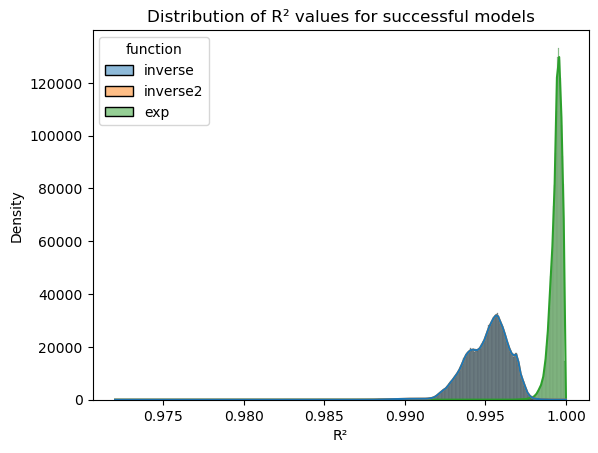

In [56]:
fig=sns.histplot(data=successful_models_df,x="r_squared",hue="function",kde=True)
plt.title("Distribution of R² values for successful models")
plt.xlabel("R²")
plt.ylabel("Density")
plt.savefig(figure_folder / "modeling_function_R2_distribution.svg")
plt.show()

In [57]:
exp_models_df = modelling_results_df.query("function == 'exp'").copy()

below_99 = exp_models_df.query("r_squared < 0.99")

In [58]:
below_99

,smiles,split,function,formula,max_nb_unique_smiles,alpha,beta,r_squared,error_log
1183719,CC(Br)(Br)C(F)(F)F,train,exp,$y = \alpha (1 - e^{-\beta x})$,42.0,41.017969,0.020458,0.986672,overflow encountered in exp
1588504,c1cnc(N2CCOCC2)c(N2CCOCC2)n1,train,exp,$y = \alpha (1 - e^{-\beta x})$,53.0,52.254047,0.017795,0.989411,overflow encountered in exp
5942674,FC(F)(Br)C(F)(F)Br,train,exp,$y = \alpha (1 - e^{-\beta x})$,63.0,61.658947,0.012800,0.987477,overflow encountered in exp; overflow encounte...
6477059,FC(F)(F)C(Cl)(Br)Br,train,exp,$y = \alpha (1 - e^{-\beta x})$,42.0,41.110401,0.018648,0.984026,overflow encountered in exp
7394519,FC(F)(F)C(F)(Br)Br,test,exp,$y = \alpha (1 - e^{-\beta x})$,42.0,41.110401,0.018648,0.984026,overflow encountered in exp


In [59]:
exp_models_df["ratio_expvstheo"]=exp_models_df["max_nb_unique_smiles"]/exp_models_df["alpha"]

In [60]:
exp_models_df["ratio_expvstheo"].describe()

count    1.936962e+06
mean     1.008796e+00
std      3.796064e-03
min      9.464385e-01
25%      1.005996e+00
50%      1.008058e+00
75%      1.011413e+00
max      1.053115e+00
Name: ratio_expvstheo, dtype: float64

In [61]:
undersmapled_exp_models_df = exp_models_df.query("ratio_expvstheo < 0.99")

In [62]:
undersmapled_exp_models_df

,smiles,split,function,formula,max_nb_unique_smiles,alpha,beta,r_squared,error_log,ratio_expvstheo
2188449,CC1(C)OC2(C)C(C)(O)C(C)(O)C(C)(O)C(C)(O)C2(C)O1,train,exp,$y = \alpha (1 - e^{-\beta x})$,300639.0,305771.799963,0.000003,0.999384,overflow encountered in exp; overflow encounte...,0.983214
2308644,CC1(CO)OC(C)(n2cnc3c(N)nc(N)nc32)C(C)(O)C1(C)O,train,exp,$y = \alpha (1 - e^{-\beta x})$,341988.0,358345.341310,0.000002,0.999367,overflow encountered in exp; overflow encounte...,0.954353
6112619,CC12CCC(C)(C(NC(=O)C34CCC(C)(C(=O)O3)C4(C)C)C1...,train,exp,$y = \alpha (1 - e^{-\beta x})$,337004.0,356075.965410,0.000002,0.998944,overflow encountered in exp; overflow encounte...,0.946438
7904894,CC(=O)OC1(C)C(C)(C(C)(O)CO)OC2(C)OC(C)(C)OC21C,train,exp,$y = \alpha (1 - e^{-\beta x})$,316076.0,324917.447581,0.000003,0.999308,overflow encountered in exp; overflow encounte...,0.972789


In [75]:
well_sampled_exp_models_df = exp_models_df.query("ratio_expvstheo >= 1.00 & ratio_expvstheo <= 1.02")

In [77]:
percentage_well_sampled = well_sampled_exp_models_df.shape[0] / exp_models_df.shape[0] * 100
print(f"Number of well sampled exp models: {well_sampled_exp_models_df.shape[0]} / {exp_models_df.shape[0]} ({percentage_well_sampled:.2f}%)    ")

Number of well sampled exp models: 1923904 / 1936962 (99.33%)    


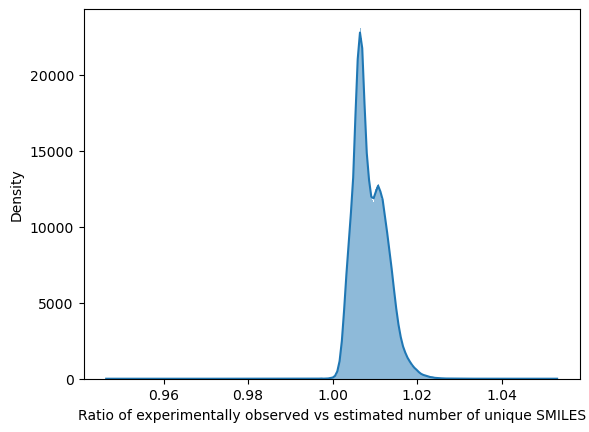

In [78]:
fig = sns.histplot(
    exp_models_df,
    x="ratio_expvstheo",
    kde=True,
    alpha=0.5,
    edgecolor=None,
    linewidth=0,
)
# plt.title("Distribution of the ratio of experimentally observed vs theoretical number of unique SMILES for the exp function")
plt.xlabel("Ratio of experimentally observed vs estimated number of unique SMILES")
plt.ylabel("Density")
plt.savefig(figure_folder / "modeling_exp_function_ratio_expvstheo_distribution.svg")
plt.show()